In [301]:
import numpy as np
import pandas as pd
#import scipy as sci
#import sympy as sym
#import statistics as stat
import random as rng
#import itertools as ite
#import time
#import math
#------------------
import matplotlib.pyplot as plt
#import matplotlib.animation as manim
import matplotlib_inline
#from matplotlib.ticker import AutoMinorLocator
#import cartopy.crs as ccrs
#from cartopy.io.img_tiles import GoogleTiles
#import timeit
#from IPython.display import display
from mpl_toolkits import mplot3d
#---------
#import json
#import os
#import gc
#import sys
#----------
#import awkward as ak
#import uproot
#import vector

In [588]:
def parti_gen(invar_m: float, counts: int, cond = 1/2, width = 0.5): #This needs to be built better at some point in the future
    moths = np.zeros((counts,4))
    daus = np.zeros((counts,4))
    moths[:,0] = np.random.uniform(invar_m*(1-width),invar_m*(1+width),counts)
    daus[:,0] = moths[:,0]*cond
    daus[:,0] = np.nextafter(daus[:,0],0)
    daus[:,0] = np.random.uniform(daus[:,0]*(1-width), daus[:,0] ,counts)
    return moths, daus

def lorenz_bst_z_iso(fourvecs, beta): #Hacky way to make the momentum plots for part 2. 
    gamma = (np.sqrt(1.0 - beta**2))**(-1)
    E = fourvecs[:, 0]
    px = fourvecs[:, 1]
    py = fourvecs[:, 2]
    pz = fourvecs[:, 3]

    E_new = gamma * (E + beta * pz)
    pz_new = gamma * (pz + beta * E)

    return np.column_stack((E_new, px, py, pz_new))

def sph_crt(phi, theta): #cartesian from spherical
    z = np.cos(theta)
    cos_phi = np.cos(phi)
    sin_phi = np.sin(phi)
    sin_theta = np.sin(theta)
    x = sin_theta * cos_phi
    y = sin_theta * sin_phi
    return x,y,z

def crt_sph(x,y,z): #spherical from cartesian
    theta = np.arccos(z)
    phi = np.arctan(y/x)
    return phi, theta
    
def iso_2dec(four_vec):
    dau = np.copy(four_vec)
    dau[0] = dau[0]/2
    invar_m = four_vec[0]/4
    dau_p = np.sqrt(dau[0]**2-invar_m**2) 
    phi = np.random.uniform(0,2*np.pi)
    z = np.random.uniform(-1, 1)
    theta = np.arccos(z)
    cos_phi = np.cos(phi)
    sin_phi = np.sin(phi)
    sin_theta = np.sin(theta)
    x = sin_theta * cos_phi
    y = sin_theta * sin_phi
    dau[1] = x*dau_p
    dau[2] = y*dau_p
    dau[3] = z*dau_p #Random directions. 
    dau2 = np.copy(dau)
    dau2[1:] = dau2[1:]*(-1)
    return [dau, dau2]

def n_cm(four_vecs):
    '''This calculates, boosts, and returns a list of four vectors boosted to their respective center of mass frame, from an input list of four vectors.'''
    cm_vecs = []
    betas = []
    for event in four_vecs:
        beta_cm = np.sum(event[:,1:], axis=0) / np.sum(event[:,0])
        betas.append(beta_cm)
        for vec in event:
            cm_vec = vec
            cm_vec = lorentz_boost(cm_vec,beta_cm)
            cm_vec[1:] = np.where(np.abs(cm_vec[1:]) < 1e-6, 0.0, cm_vec[1:])
            cm_vecs.append(cm_vec)
    return [cm_vecs, betas]

def invar_mass(four_vec):
    invar_m = four_vec[0]**2-np.sum(four_vec[1:]**2)
    return np.sqrt(invar_m)


def lorentz_boost(four_vec, beta): #Generalized lorentz booster for four vectors (thank you wikipedia for the giant matrix) 
    '''Takes in a four vec, a boost row vector beta as a numpy (1,3) array, which gives its boost amount and direction. (To be used as (3,1) insde.)
    Remember, this boosts the observer, so negative boosts the particle upwards for an observer going downwards. 
    '''
    beta = beta.reshape(3,1)
    if np.linalg.norm(beta) == 0:
        return four_vec
    I = np.array([[1,0,0],[0,1,0],[0,0,1]])
    px,py,pz = four_vec[1:]
    boost_vec = four_vec.copy()
    beta_sqr = ( np.linalg.norm(beta) ) **2
    gamma = ( 1 - beta_sqr )**(-0.5)
    beta_transp = beta.T
    loren_mat = np.block([[np.array([[gamma]]), -gamma*beta_transp], [-gamma*beta, (gamma - 1)*(np.matmul(beta,beta_transp))/beta_sqr + I]])

    boost_vec = np.matmul(loren_mat,four_vec)
    return boost_vec

    
def momentum(moth_mass,dau_m1,dau_m2):
    p_dau = np.sqrt((moth_mass**2 - (dau_m1+dau_m2)**2)*(moth_mass**2 - (dau_m1-dau_m2)**2))/(2*moth_mass) #General momentum formula
    return p_dau

def gen_iso(p):
    cos_theta = np.random.uniform(-1,1)
    phi = np.random.uniform(0,2*np.pi)
    sin_theta = np.sqrt(1-cos_theta**2)
    px = p*sin_theta*np.cos(phi)
    py = p * sin_theta*np.sin(phi)
    pz = p * cos_theta
    return np.array([px,py,pz])
       
def two_decay_gen(moth_mass, twins=True, uncert_moth=0.1, count=100):
    '''Takes in a theoretical mother mass for a particle in its rest frame, a decay boolean for identical daughters, an uncertainty for the mass
    of the mother, and an event count.
    Using a normal distribution to sample the masses, within uncertainty, the angles are then uniformly sampled for the corresponding momentums. 
    '''
    ECMs = np.random.normal(loc=moth_mass, scale=uncert_moth * moth_mass, size=count)
    dau_m1s = np.array([np.random.uniform(0.001 * M, 0.4999 * M) for M in ECMs])
    if not twins:
        dau_m2s = np.array([np.random.uniform(0.1*(M-m1), M - m1 - 0.001) for M, m1 in zip(ECMs, dau_m1s)])
        momens = np.array([momentum(M, m1, m2) for M, m1, m2 in zip(ECMs, dau_m1s, dau_m2s)])
        directs = np.array([gen_iso(p) for p in momens])
        daus = np.column_stack((np.sqrt(momens**2 + dau_m1s**2), directs))
        dau2s = np.column_stack((np.sqrt(momens**2 + dau_m2s**2), -directs))
    else:
        momens = np.array([momentum(M, m, m) for M, m in zip(ECMs, dau_m1s)])
        directs = np.array([gen_iso(p) for p in momens])
        daus = np.column_stack((np.sqrt(momens**2 + dau_m1s**2), directs))
        dau2s = np.column_stack((np.sqrt(momens**2 + dau_m1s**2), -directs))
    moths_moments = np.zeros((count, 3))
    moths = np.column_stack((ECMs, moths_moments))
    return moths, daus, dau2s
    
def to_rest(four_vec):
    m = invar_mass(four_vec)
    beta = (-1)*four_vec[1:]/four_vec[0]
    bst_vec = lorentz_boost(four_vec,beta)
    return np.array([m,0,0,0]), (-1)*beta
    
    

(array([ 306.55743834,   -9.71220532, -126.2930308 , -101.94075389]),
 array([613.11487668,   0.        ,   0.        ,   0.        ]),
 array([306.55743834,   9.71220532, 126.2930308 , 101.94075389]))

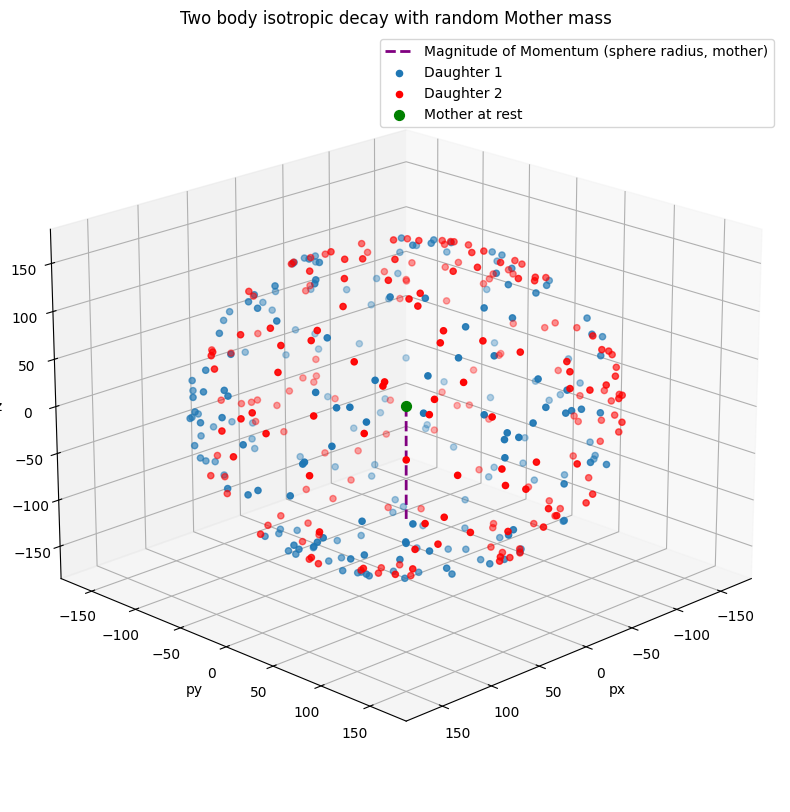

In [589]:

counts = 200

phi = np.random.uniform(0,2*np.pi, counts)
z = np.random.uniform(-1, 1, counts) 
theta = np.arccos(z)
cos_phi = np.cos(phi)
sin_phi = np.sin(phi)
sin_theta = np.sin(theta)
x = sin_theta * cos_phi
y = sin_theta * sin_phi

moths, daus = parti_gen(511,counts)
moth = np.copy(moths[0])
dau = np.copy(daus[0])
p_dau = np.sqrt(moth[0]**2 / 4 - dau[0]**2) #Observation, p < m possibly non relativistic, p > m, more likely relativistic
E_dau = np.sqrt(p_dau**2 + dau[0]**2)  #Fix energy component of daughters
px = p_dau * x
py = p_dau *y
pz = p_dau * z 

dau[0], dau[1], dau[2], dau[3] = E_dau,px[0],py[0],pz[0]
dau2 = np.copy(dau)
dau2[1:] = dau2[1:]*(-1)



limax = p_dau * 1.05
fig, ax = plt.subplots(1, 1, figsize=(12, 10), subplot_kw={"projection": "3d"})
ax.plot([0, p_dau], [0, p_dau], [0, 0], color='purple', linestyle='--', linewidth=2, label='Magnitude of Momentum (sphere radius, mother)')
ax.scatter(px,py,pz, label='Daughter 1')
ax.scatter(-px,-py,-pz,color = 'red', label='Daughter 2')
ax.set_title("Two body isotropic decay with random Mother mass")
ax.set_ylabel('py')
ax.set_xlabel("px")
ax.set_zlabel("pz")
ax.scatter(0, 0, 0, color='green', s=50, label='Mother at rest')
ax.legend()
ax.view_init(elev=20, azim=45)
dau, moth, dau2

In [590]:
# 3.  Generate a set of decays as follows (this uses the ingredients developed in (1) and (2)). 
# The overall frame of interest is one where the total 3-momentum of all particles sums to zero and the total energy of all particles sums to ECM.  
# In this frame, generate the production of two particles of mass M so that their energies sum to ECM and their three-momenta sum to zero. 
# Decay each of these particles independently into two particles of mass m, where the decay is isotropic in the rest frame of the parent particle M. 
# Boost the momenta of the particles of mass m to the overall rest frame (the frame in which the M particles were generated). 
# Verify that the sum of the 4-vectors of the four particles of mass m gives the 4-vector (0,0,0,ECM). 
# And that the corresponding pair-wise combinations of (m,m) have invariant masses equal to the mass of the parent M particle.
 
# 4.  Plot all pairwise combinations (i.e. 6 combinations m_i,m_j in each event).  Think about what the plot shows.
  
# 5.  If you're ambitious, repeat the above where the M particle decays into two particles with different masses, i.e. m1, m2 where m1+m2 < M. 
'''Generator version'''
count = 10000
uncert = 0.2
twins = True
moths, dau1s, dau2s = two_decay_gen(511, twins, uncert, count)
b_dau1s, betas = zip(*[to_rest(p) for p in dau1s])
b_dau2s, betas2 = zip(*[to_rest(p) for p in dau2s])

b_dau1s = np.array(b_dau1s)
betas = np.array(betas)
b_dau2s = np.array(b_dau2s)
betas2 = np.array(betas2)

gdau12 = [two_decay_gen(invar_mass(p), True, 0, 1) for p in b_dau1s]
gdau34 = [two_decay_gen(invar_mass(p), True, 0, 1) for p in b_dau2s]

gdau1s = np.array([gen[1][0] for gen in gdau12], dtype=np.float64)
gdau2s = np.array([gen[2][0] for gen in gdau12], dtype=np.float64)
gdau3s = np.array([gen[1][0] for gen in gdau34], dtype=np.float64)
gdau4s = np.array([gen[2][0] for gen in gdau34], dtype=np.float64)

gd1rs = np.vstack([lorentz_boost(p, b) for p, b in zip(gdau1s, betas)])
gd2rs = np.vstack([lorentz_boost(p, b) for p, b in zip(gdau2s, betas)])
gd3rs = np.vstack([lorentz_boost(p, b) for p, b in zip(gdau3s, betas2)])
gd4rs = np.vstack([lorentz_boost(p, b) for p, b in zip(gdau4s, betas2)])

g12 = gd1rs+gd2rs
g34 = gd3rs+gd4rs
g13 = gd1rs + gd3rs
g14 = gd1rs + gd4rs
g23 = gd2rs + gd3rs
g24 = gd2rs + gd4rs

inv_12 = [invar_mass(vec) for vec in g12]
inv_34 = [invar_mass(vec) for vec in g34]
inv_13 = [invar_mass(vec) for vec in g13]
inv_14 = [invar_mass(vec) for vec in g14]
inv_23 = [invar_mass(vec) for vec in g23]
inv_24 = [invar_mass(vec) for vec in g24]

# gd1rs+gd2rs+gd3rs+gd4rs, moths #All grand daughters sum to (ECM,0,0,0). 

# inv_12, b_dau1s, inv_34,b_dau2s #Yes, corresponding pair-wise combinations of (m,m) have invariant masses equal to the mass of the parent M particle.

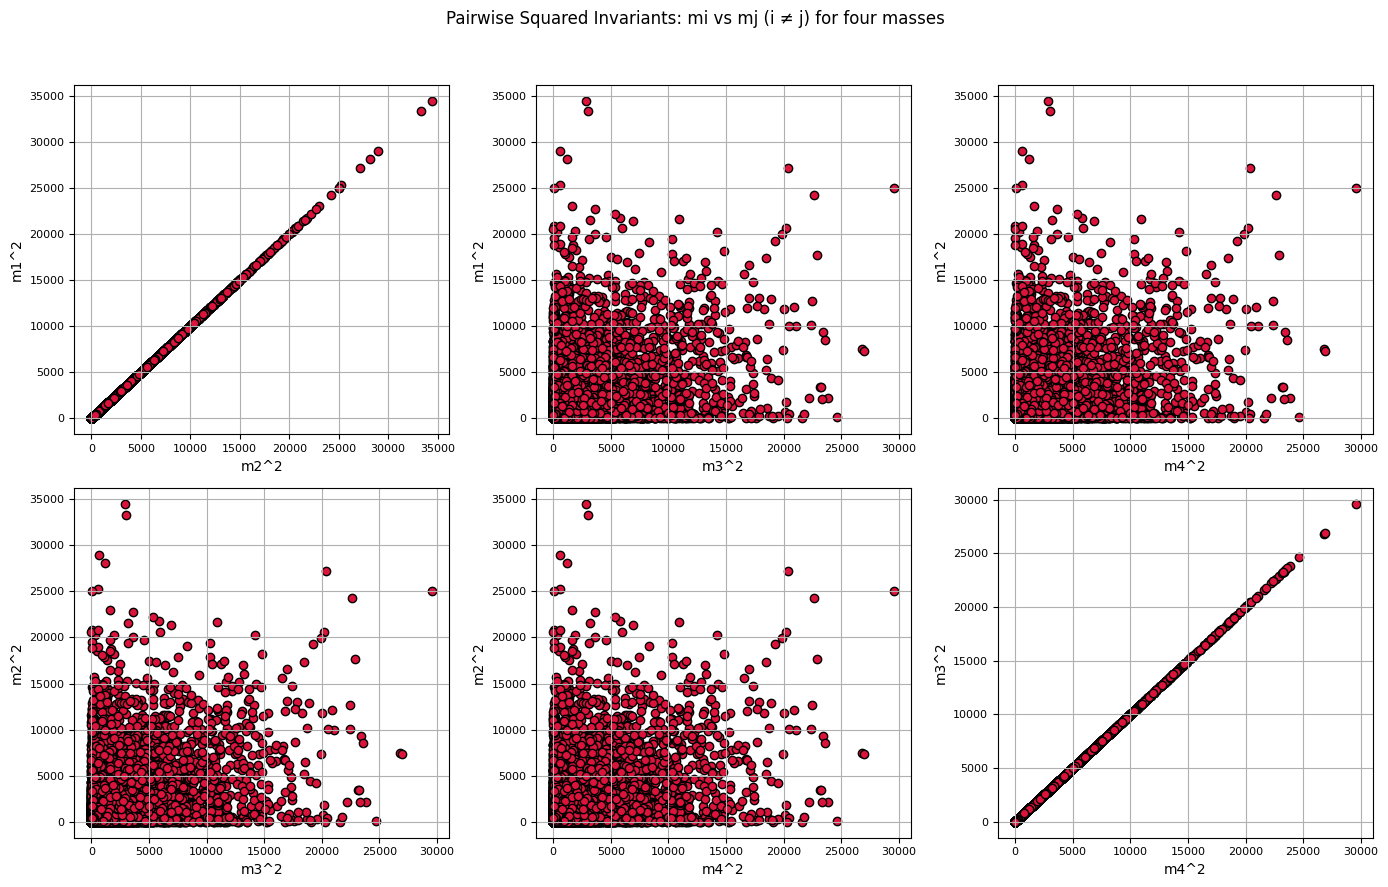

In [591]:
invars = [gd1rs, gd2rs, gd3rs, gd4rs]
masses_sq = [[invar_mass(p)**2 for p in group] for group in invars]
mass_labels = ['m1^2', 'm2^2', 'm3^2', 'm4^2']

pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

fig, axs = plt.subplots(2, 3, figsize=(14, 9))
fig.suptitle('Pairwise Squared Invariants: mi vs mj (i ≠ j) for four masses')

axs = axs.flatten()

plot_index = 0
for i, j in pairs:
    axs[plot_index].scatter(masses_sq[j], masses_sq[i], edgecolors='k', color='crimson')
    axs[plot_index].grid(True)
    axs[plot_index].set_xlabel(mass_labels[j], fontsize=10)
    axs[plot_index].set_ylabel(mass_labels[i], fontsize=10)
    axs[plot_index].tick_params(axis='both', which='major', labelsize=8)
    plot_index += 1

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [583]:
#There is a linear correlation between the true daughter pairs m1 m2 and m3 m4's invariant. Meanwhile the daughters that are not pairs are scattered without any discernable graphcial relation.